### Importing Essential Libraries

In [1]:
import random
import os

import numpy as np
import pickle

import pandas as pd
pd.set_option('display.width', 1000)

# !pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
from time import sleep

import re
# !pip install unidecode
from unidecode import unidecode


from matplotlib import pyplot as plt
%matplotlib inline
# !pip install seaborn
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import Module, Linear, Dropout
from torch.nn import Softmax
from torch.optim import AdamW
# !pip install torchmetrics
from torchmetrics import F1Score, Precision, Recall, Accuracy


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

# !pip install transformers
from transformers import BertTokenizer, BertModel

from transformers import logging
logging.set_verbosity_error()

/home/giorgo/anaconda3/envs/ai2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paths

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# ROOT = 'gdrive/My Drive/ai2_data/4/' # ^ Google drive  

ROOT = './' # local

DATASETS     = ROOT + 'datasets/'
SAVED_MODELS = ROOT + 'saved_models/'
PLOTS        = ROOT + 'plots/'

### Helpers

In [3]:
def write_data(path, obj):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_data(path):
    return pd.read_pickle(path)

def load_csv(path, sep='\t'):
    return pd.read_csv(path, sep=sep)

### Preprocessing

In [4]:
def get_dfs(small=True):
    names   = ['ent_id', 'rel_id', 'ans_id', 'text']
    datasets = ['train', 'valid', 'test']
    return [pd.read_csv(f'{DATASETS}annotated_wd_data_{i}{"_answerable" if small else ""}.txt', sep='\t', names=names) for i in datasets]

#### Retrieval of values of the wikidata ids

In [5]:
def wikidata_ent_lookup(sparql, ids):

    q =f'''
           SELECT ?item ?itemLabel 
           WHERE {{
            VALUES ?item {{ {' '.join([f'wd:{i}' for i in ids])} }}
            SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
            }}
        '''

    sparql.setQuery(q)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    results_df = pd.json_normalize(results['results']['bindings'])

    df = pd.DataFrame()
    df['id'] = results_df['item.value'].map(lambda x : x.split('/')[-1])
    df['label'] = results_df['itemLabel.value']

    sleep(1) # Avoid timeout

    return df

def get_id_labels(ids, batch_size=500, small=True, load=False):

    if load:
        return pd.read_csv(DATASETS + f'{"small" if small else "big"}_rel_vocab.csv', sep='\t')

    # Specify the DBPedia endpoint
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    
    sublists = []

    n = len(ids) // batch_size

    for i in range(n):
        sublists.append(ids[batch_size * i:batch_size * (i + 1)])
    
    sublists.append(ids[n * batch_size:])
    
    return pd.concat([wikidata_ent_lookup(sparql, l) for l in sublists])

In [6]:
def df_vocabs(small=True, batch_size=500, load=False):
    df_train, df_val, df_test = get_dfs(small=small)
    rel_vocab = list(set(df_train['rel_id']).union(set(df_val['rel_id'])).union(df_test['rel_id']))
    ent_vocab = list(set(df_train['ent_id']).union(set(df_val['ent_id'])).union(df_test['ent_id']))

    df = get_id_labels(ent_vocab, batch_size=batch_size, load=load)

    df.to_csv(DATASETS + f'{"small" if small else "big"}_ent_id_to_ent.csv', sep='\t', index=False)

    df = pd.DataFrame()
    df['id'] = rel_vocab

    df.to_csv(DATASETS + f'{"small" if small else "big"}_rel_vocab.csv', sep='\t', index=False)

In [7]:
# Run only once
# df_vocabs(small=True)
# df_vocabs(small=False)

In [7]:
def clean_str(str):
    str = unidecode(str.lower())
    return ' '.join(re.sub(r"'s|[^a-z]", " ", str).split())

def span(row, ids):
    text = clean_str(row['text']).split()

    if row['ent_id'] not in ids.keys():
        return np.zeros(len(text), dtype=int)

    sub  = clean_str(ids[row['ent_id']][0])

    n = sub.count(' ') + 1
    grams = [' '.join(j) for j in [text[i: i + n] for i in range(len(text) - n + 1)]]

    if sub not in grams:
        return np.zeros(len(text), dtype=int)

    a = grams.index(sub)
    return np.array([int(i >= a and i < a + n) for i in range(0, len(text))])

def spans(df, ids):
    df['span'] = df[['ent_id', 'text']].apply(lambda x : span(x, ids), axis=1)
    df['start'] = df['span'].map(lambda x : np.where(x == 1)[0][0] if np.any(x) else -1)
    df['end'] = df['span'].apply(lambda x : np.where(x == 1)[0][-1] if np.any(x) else -1)
    df.drop('span', axis=1, inplace=True)
    return df

In [8]:
def prepare_data(small=True):
    ent_path = f'{"small" if small else "big"}_ent_id_to_ent.csv'
    rel_path = f'{"small" if small else "big"}_rel_vocab.csv'

    df_train, df_val, df_test = get_dfs(small=small)

    df = pd.read_csv(DATASETS + ent_path, sep='\t')
    ids = df.set_index('id').T.to_dict('list')

    df_train, df_val, df_test = spans(df_train, ids), spans(df_val, ids), spans(df_test, ids)
    st = set(df_train['start']).union(set(df_val['start']).union(set(df_test['start'])))
    en = set(df_train['end']).union(set(df_val['end']).union(set(df_test['end'])))

    df = pd.read_csv(DATASETS + rel_path, sep='\t')
    ids = list(df['id'].values)

    df_train['rel'] = df_train['rel_id'].map(lambda x : ids.index(x))
    df_val['rel'] = df_val['rel_id'].map(lambda x : ids.index(x))
    df_test['rel'] = df_test['rel_id'].map(lambda x : ids.index(x))

    write_data(DATASETS + 'train.pkl', df_train)
    write_data(DATASETS + 'val.pkl', df_val)
    write_data(DATASETS + 'test.pkl', df_test)

    # Returns: possible values for span start [0,s], 
    #          possible values for span end   [0,e],
    #          possible values for relation   [0,r]
    return max(st) + 1, max(en) + 1, len(df)

### Dataset

In [9]:
class ClassifierData(Dataset):
    def __init__(self, dataset, x_label='text', y_label='rel', 
                 load=True, device='cuda'):
        
        self.device = device
        
        df = load_data(dataset) if load else dataset
        
        # drop rows with zero vectors for span when predictin span, since they are not useful
        # Around 8.5% for each df, acceptable
        if y_label != 'rel':
            df.drop(df[df.start == -1].index, inplace=True)

        # Load pre-trained model tokenizer (vocabulary)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        encoded = tokenizer.batch_encode_plus(df[x_label].values,
                                              add_special_tokens=True,
                                              return_attention_mask=True,
                                              padding=True, truncation=True,
                                              max_length=32, # for our dataset the max length is 33 so this is not really an issue
                                              return_tensors='pt'
                                            )

        self.inputs = encoded['input_ids']
        self.masks = encoded['attention_mask']

        self.labels = [int(i) for i in df[y_label].values]
        self.labels = torch.tensor(self.labels)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.inputs[index].to(self.device), self.masks[index].to(self.device), self.labels[index].to(self.device)

In [10]:
def get_datasets(path, y_label='rel'):
    train = ClassifierData(path + 'train.pkl', y_label=y_label)
    val   = ClassifierData(path + 'val.pkl', y_label=y_label)
    test  = ClassifierData(path + 'test.pkl', y_label=y_label)
    return train, val, test

In [11]:
def get_dataloaders(train_data, val_data, test_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

### Train & Test

In [12]:
def test(dataloader, model, loss_fn, device, classes):
    model.eval()

    samples = len(dataloader)
    loss = 0.0
    predicted, target = [], []
    
    with torch.no_grad():
        for X, masks, y in dataloader:

            pred = model(input_ids=X, attention_mask=masks)   
            loss += loss_fn(pred, y).item()
            
            predicted.append(pred)             
            target.append(y)             
    
    predicted = torch.cat(predicted, dim=0).to(device)
    target = torch.cat(target, dim=0).to(device)

    preds = torch.argmax(predicted, dim=1).to(device)
    
    p = Precision(task='multiclass', num_classes=classes, average='weighted').to(device)
    r = Recall(task='multiclass', num_classes=classes, average='weighted').to(device)
    f1 = F1Score(task='multiclass', num_classes=classes, average='weighted').to(device)
    acc = Accuracy(task='multiclass', num_classes=classes).to(device)
    
    p  =  p(predicted, target).item()
    r  =  r(predicted, target).item()
    f1 = f1(predicted, target).item()
    acc = acc(predicted, target).item()

    return loss / samples, p, r, f1, acc, preds.detach().cpu().numpy(), target.detach().cpu().numpy()

In [13]:
def epoch(model, dataloader, loss_fn, optimizer, clip):
    model.train()
    running_loss = 0.0

    predicted, target = [], []

    for X, masks, y in dataloader:
        pred = model(input_ids=X, attention_mask=masks)   
    
        predicted.append(pred)
        target.append(y)
        
        loss = loss_fn(pred, y)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
    
    return predicted, target, running_loss

In [15]:
def validate_model(model, device, dataloader, metrics, loss_fn, classes, show_epochs=False):
    val_loss, _, _, f1, acc, _, _ = test(dataloader, model, loss_fn, device, classes)
    
    if show_epochs:
        print(f'Loss on validation set: {val_loss}')
        print(f'Accuracy on validation set: {acc*100:>.2f}')
        print(f'F1-score on validation set: {f1*100:>.2f}')

    metrics['loss']['test'].append(val_loss)
    metrics['f1']['test'].append(f1)
    
    return metrics

In [14]:
def train(dataloader, model, epochs, loss_fn, optimizer, classes, val_dataloader, clip=None, device='cpu', show_epochs=False):
    metrics = {'loss' : {'train' : [], 'test' : []}, 
               'f1' : {'train' : [], 'test' : []}}

    for t in range(epochs):
        batches = len(dataloader)

        if show_epochs:
            print(f'\nEpoch {t+1}\n{"-" * 50}')

        predicted, target, running_loss = epoch(model, dataloader, loss_fn, optimizer, clip)

        epoch_loss = running_loss / batches
        metrics['loss']['train'].append(epoch_loss)

        predicted = torch.cat(predicted, dim=0).to(device)
        target = torch.cat(target, dim=0).to(device)
        
        f1 = F1Score(task='multiclass', num_classes=classes, average='weighted').to(device)
        metrics['f1']['train'].append(f1(predicted, target).item())

        if show_epochs:
            print(f'Loss on train set     : {epoch_loss}')
            print(f'F1-score on train set: {metrics["f1"]["train"][-1]*100:>.2f}')

        if val_dataloader:
            metrics = validate_model(model, device, val_dataloader, metrics, loss_fn, classes, show_epochs)
            
    return metrics

### Complete Pass

#### Reproducibility

In [16]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

#### Learning Curve

In [17]:
# Based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def helper(train, test, xlabel, ylabel, f1=False, id=None):
    fig, axes = plt.subplots(1, 1, figsize=(8,5))

    axes.set_xlabel('Epoch')
    axes.set_ylabel('F1-Score' if f1 else 'Loss')

    axes.grid()

    epoch_step = len(train) // 20
    if not epoch_step:
        epoch_step = 1

    xvalues = np.arange(1, len(train) + 1, epoch_step)

    axes.plot(xvalues, train[::epoch_step], "o-", color="r", label=xlabel)
    axes.plot(xvalues, test[::epoch_step], "o-", color="g", label=ylabel)

    axes.legend(loc="best")

    plt.xticks(np.arange(1, len(train) + epoch_step + 1, epoch_step))

    max_stat = max(max(train), max(test)) 
    step = 0.05 if f1 else max_stat / 10
    low = 0.50 if f1 else 0.
    high = 1.01 if f1 else max_stat + step

    plt.yticks(np.arange(low, high, step))

    if id:
        name = 'f1' if f1 else 'loss'
        fig.savefig(f'{PLOTS}{name}/{id}_{name}.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    

def learning_curve(metrics, id=None):
    helper(np.array(metrics['f1']['train']), np.array(metrics['f1']['test']), 'Training F1-Score', 'Validation F1-Score', f1=True, id=id)
    helper(np.array(metrics['loss']['train']), np.array(metrics['loss']['test']), 'Training loss', 'Validation loss', id=id)

#### Pass

In [18]:
def complete_pass(data_path, model, **kwargs):
    torch.cuda.empty_cache()
    # Data 
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 16
    y_label = kwargs['y_label'] if 'y_label' in kwargs else 'rel'

    # Architecture
    model_params = kwargs['model_params'] if 'model_params' in kwargs else {}

    # Hyperparameters
    device = kwargs['device'] if 'device' in kwargs else 'cpu'
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    
    loss_fn = kwargs['loss_fn'] if 'loss_fn' in kwargs else nn.CrossEntropyLoss()
    lr = kwargs['lr'] if 'lr' in kwargs else 0.002

    optimizer = kwargs['optimizer'] if 'optimizer' in kwargs else AdamW
    kwargs.pop('optimizer', None)
    optimizer_params = kwargs['optimizer_params'] if 'optimizer_params' in kwargs else {}

    clip = kwargs['clip'] if 'clip' in kwargs else None

    # Results
    show_epochs = kwargs['show_epochs'] if 'show_epochs' in kwargs else False
    lc = kwargs['lc'] if 'lc' in kwargs else False
    reproducibility = kwargs['reproducibility'] if 'reproducibility' in kwargs else False
    id = kwargs['id'] if 'id' in kwargs else False

    if reproducibility:
          torch_seed(seed=5)

    train_data, val_data, test_data = get_datasets(data_path, y_label=y_label)
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_data, val_data, test_data, batch_size)
    
    model = model(**model_params).to(device)

    optimizer = optimizer(model.parameters(), lr=lr, **optimizer_params)

    metrics = train(train_dataloader, model, epochs, loss_fn, optimizer, model_params['out_dim'], val_dataloader, clip, device, show_epochs)


    loss, p, r, f1, acc, _, _ = test(test_dataloader, model, loss_fn, device, model_params['out_dim'])

    print(f'\n\nAvg loss: {loss:>8f}\tAccuracy: {(100*acc):>0.2f}%')
    print(f'Precision: {(100*p):>0.2f}%\tRecall: {(100*r):>0.2f}%\t\tF1-Score: {(100*f1):>0.2f}%')

    if id:
        write_data(f'{SAVED_MODELS + id}.pkl', model)


    if lc:
        learning_curve(metrics)
    
    del model

### Network

In [19]:
class NeuralNetwork(Module):
    def __init__(self, in_dim, out_dim, dropout):
        super(NeuralNetwork, self).__init__()

        self.dropout = Dropout(dropout)
        self.linear = Linear(in_dim, out_dim)
        self.softmax = Softmax(dim=1)

    def forward(self, x):            
        return self.softmax(self.linear(self.dropout(x)))

In [20]:
class Bert(nn.Module):
    def __init__(self, bert, bert_name, out_dim, dropout):
        super(Bert, self).__init__()

        self.bert  = bert.from_pretrained(bert_name)
        self.fc  = NeuralNetwork(self.bert.config.hidden_size, out_dim, dropout)
    
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        return self.fc(out[1])

### Experiments

In [21]:
starts, ends, rels = prepare_data(small=True)



Avg loss: 1.947232	Accuracy: 92.70%
Precision: 90.41%	Recall: 92.70%		F1-Score: 91.38%


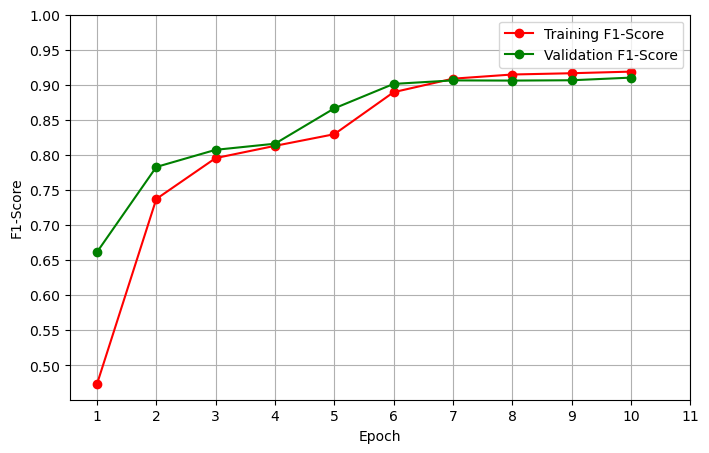

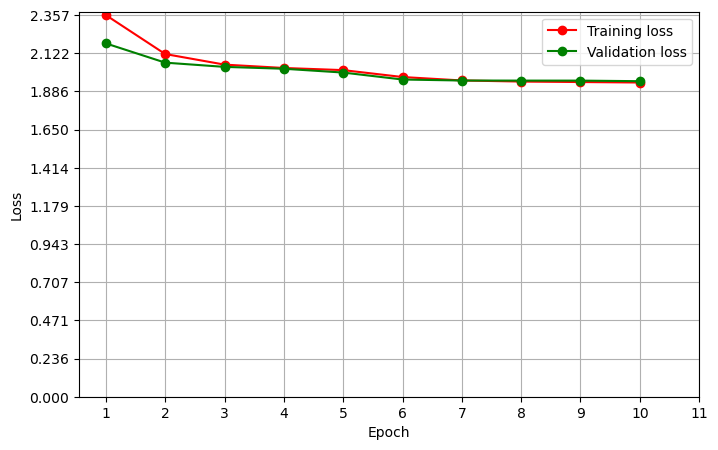

In [22]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=False, lc=True, id='start_model',
              
              y_label='start',
              device='cuda', lr=1e-5, epochs=10, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'out_dim' : starts, 'dropout' : 0.4},
              
              clip=1
              )



Avg loss: 2.076626	Accuracy: 85.37%
Precision: 80.79%	Recall: 85.37%		F1-Score: 82.72%


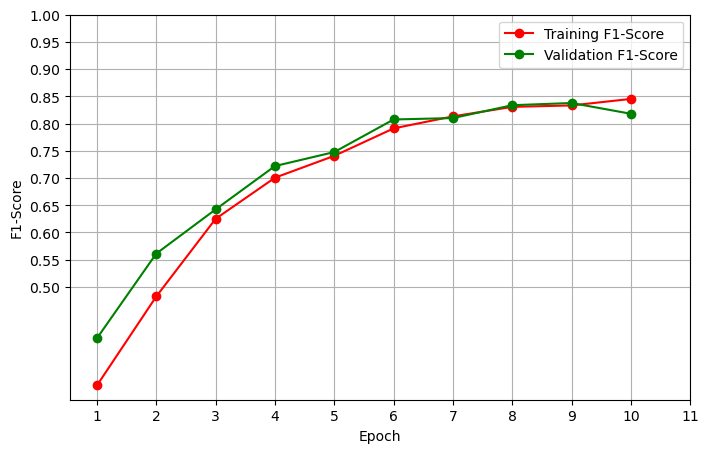

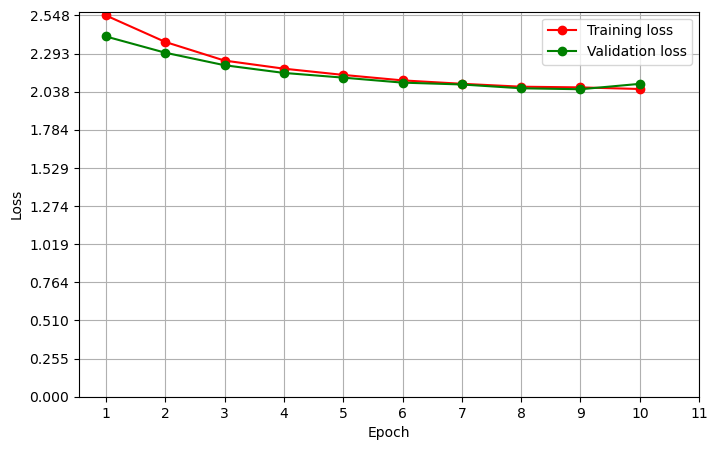

In [23]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=False, lc=True, id='end_model',
              
              y_label='end',
              device='cuda', lr=1e-5, epochs=10, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'out_dim' : ends, 'dropout' : 0.4},
              
              clip=1
              )



Avg loss: 3.975764	Accuracy: 87.80%
Precision: 82.05%	Recall: 87.80%		F1-Score: 84.37%


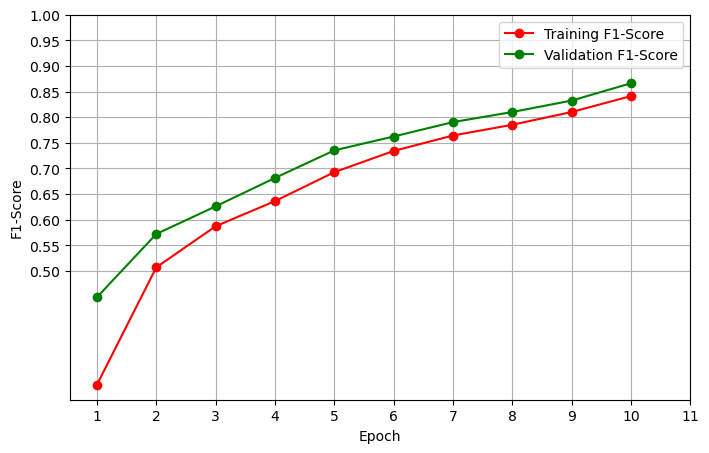

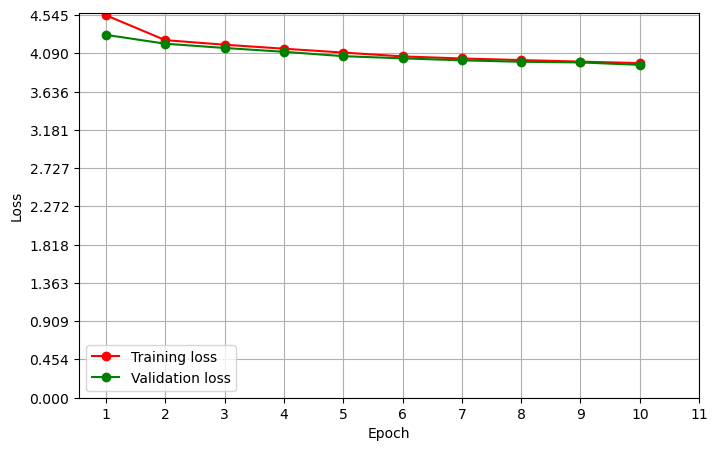

In [25]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=False, lc=True,
              
              y_label='rel',
              device='cuda', lr=1e-5, epochs=10, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'out_dim' : rels, 'dropout' : 0.4},
              
              clip=1
              )



Avg loss: 3.927457	Accuracy: 91.78%
Precision: 88.97%	Recall: 91.78%		F1-Score: 89.87%


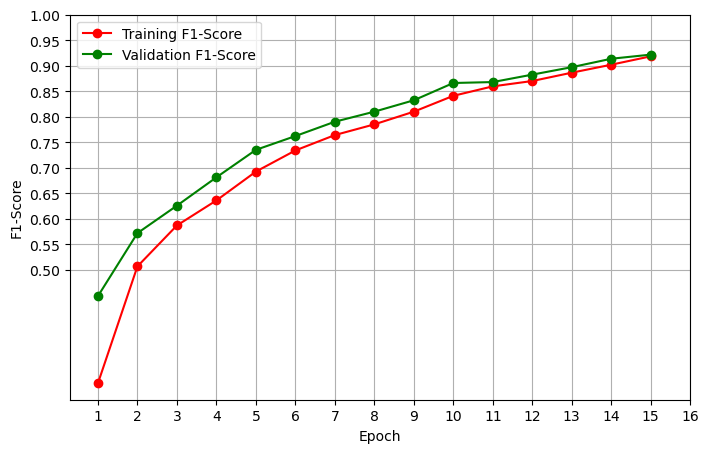

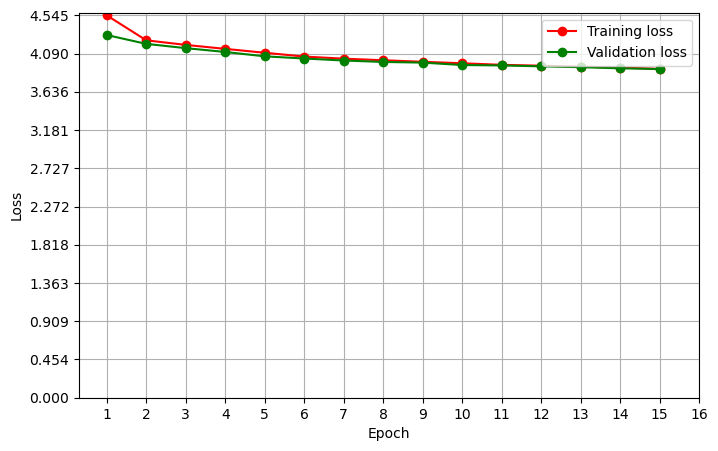

In [24]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=False, lc=True, id='rel_model',
              
              y_label='rel',
              device='cuda', lr=1e-5, epochs=15, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'out_dim' : rels, 'dropout' : 0.4},
              
              clip=1
              )